In [169]:
import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns; import os; 
from sys import platform; import numpy as np; from scipy.stats import spearmanr;

from random import seed

In [170]:
home = os.path.expanduser('~/Documents/'); data_dir = os.path.join(home, 'dynamic_decision_policy_reconfiguration/aggregated_data/loki_0')

ls_df = pd.read_csv(os.path.join(data_dir, 'ls_reward_df.csv'))

In [171]:
ls_df.head(); ls_df.columns

Index(['cpp', 'b_t0', 'b_t1', 'MC', 'H', 'signed_B_diff', 'ideal_B',
       'lambda_val', 'p_optimal', 'trial', 'subj_id', 'reward_code',
       'condition', 'run', 'LR_choice', 'value_accuracy', 'value_LR_solution',
       'reward', 'cumulative_reward', 'rt', 'total_trial_time', 'iti',
       'cp_list', 'obs_cp_list', 'high_val_cue', 'high_p_cue', 'p_accuracy',
       'p_LR_solution', 'p_id_solution', 'id_choice', 'stim_duration',
       'stim_onset', 'stim_offset', 'abs_response_time', 'epoch_length',
       'epoch_trial', 'epoch_number', 'shifted_epoch_trial'],
      dtype='object')

In [172]:
ls_df_pared = ls_df.loc[(ls_df.shifted_epoch_trial >= -1) & (ls_df.shifted_epoch_trial <= 3)].reset_index(drop=True)

## Quantifying the correlation between $\Delta B$ and $\Omega$

In [173]:
ls_df_pared.groupby(['subj_id'])[['ideal_B', 'cpp']].corr(method='spearman') # subject-wise correlation 

ideal_B       cpp
subj_id                            
786     ideal_B  1.000000 -0.274242
        cpp     -0.274242  1.000000
787     ideal_B  1.000000 -0.247258
        cpp     -0.247258  1.000000
788     ideal_B  1.000000 -0.194763
        cpp     -0.194763  1.000000
789     ideal_B  1.000000 -0.220673
        cpp     -0.220673  1.000000

In [174]:
ls_df_pared[['ideal_B', 'cpp']].corr(method='spearman') # pooled correlation

,ideal_B,cpp
ideal_B,1.000000,-0.232458
cpp,-0.232458,1.000000


## An estimate of confidence 

### percentile bootstrap of the correlations (95% CI)

In [175]:
def pairwise_percentile_bootstrap(x, y, n_resamples=1000, func=spearmanr):
    
    idx = np.arange(len(x))
    size = len(idx)
    
    resampled_x, resampled_y = list(), list()
    
    resampled_spearman_r = list() 
    
    for n in range(n_resamples):
        
        resampled_idx = np.random.choice(idx, size=size, replace=True)   # resample indices with replacement
        
        resampled_x_n, resampled_y_n = x[resampled_idx], y[resampled_idx] # get resampled values of x & y 
        
        corr_n, _ = spearmanr(resampled_x_n, resampled_y_n) # correlation of resampled values (ignore p-value)
        
        resampled_x.append(resampled_x_n); resampled_y.append(resampled_y_n) # storing resampled vectors

        resampled_spearman_r.append(corr_n) # storing correlation of resampled values
    
    return resampled_x, resampled_y, resampled_spearman_r

In [176]:
def viz_percentiles(resampled_metrics, ci = 95):
    
    sorted_resampled_metrics = np.sort(resampled_metrics)

    lw = 2; font_scale = 1.5
    
    symmetric_ci = (100 - ci )/ 2 
    symmetric_upper_bound, symmetric_lower_bound = 100 - symmetric_ci, symmetric_ci
    metric_percentiles = np.percentile(a=sorted_resampled_metrics, q=[symmetric_upper_bound, symmetric_lower_bound])
    
    mean_metric = np.mean(metric_percentiles)
    
    sns.set(font_scale=font_scale, style='whitegrid')  

    sns.histplot(sorted_resampled_metrics)
    plt.axvline(metric_percentiles[0], color='gray',linewidth=lw)
    plt.axvline(metric_percentiles[1], color='gray', linewidth=lw)
    plt.axvline(mean_metric, color='gray', linewidth=lw)
    sns.despine()
    
    return None

In [177]:
x,y = ls_df_pared.cpp, ls_df_pared.ideal_B
resampled_x, resampled_y, resampled_spearman_r = pairwise_percentile_bootstrap(x,y)

Text(0.5, 0, "Spearman's $\\rho_{B\\Omega}$")

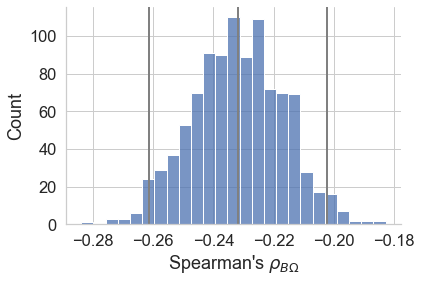

In [178]:
viz_percentiles(resampled_spearman_r)
plt.xlabel(r"Spearman's $\rho_{B\Omega}$")

### Variance Inflation Factor (VIF) & 95% CI

In [179]:
def compute_variance_inflation_factor(correlations):

    vifs = [(1 / (1 - r**2)) for r in correlations]

    return vifs

In [180]:
vifs = compute_variance_inflation_factor(resampled_spearman_r)

Text(0.5, 0, 'Variance Inflation Factor (VIF)')

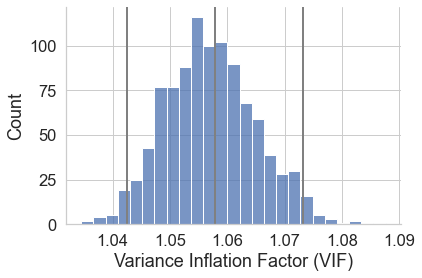

In [181]:
viz_percentiles(vifs)
plt.xlabel("Variance Inflation Factor (VIF)")